In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, skew
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time

In [2]:
##匯入資料
df_data_train = pd.read_csv("/home/jovyan/house sale price/train.csv")
df_data_test = pd.read_csv("/home/jovyan/house sale price/test.csv")
testID=df_data_test["Id"]
trainID = df_data_train['Id']
df_data_train.drop("Id", axis = 1, inplace = True)
df_data_test.drop("Id", axis = 1, inplace = True)

In [7]:
len(df_data_train.columns)

81

In [8]:
len(df_data_test.columns)

80

## 處理outlier

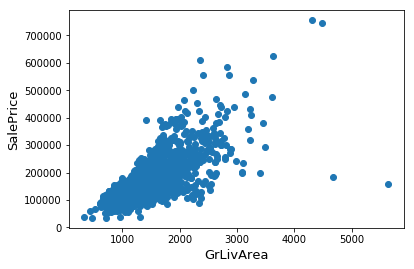

In [3]:
'''
version 1 : deal with outlier

#Relationship with numerical variables
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_data_train['SalePrice'], df_data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

df_data_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

#deleting outliar points
df_data_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_data_train = df_data_train.drop(df_data_train[df_data_train['Id'] == 1299].index)
df_data_train = df_data_train.drop(df_data_train[df_data_train['Id'] == 524].index)
'''
fig, ax = plt.subplots()
ax.scatter(x = df_data_train['GrLivArea'], y = df_data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Deleting outliers
df_data_train = df_data_train.drop(df_data_train[(df_data_train['GrLivArea']>4000) & (df_data_train['SalePrice']<300000)].index)

ntrain = df_data_train.shape[0]
ntest = df_data_test.shape[0]

## 處理sales price

In [4]:
# normalize
#取log使其接近常態分佈
#applying log transformation
df_data_train['SalePrice'] = np.log(df_data_train['SalePrice'])

## Features engineering

In [5]:
all_data = pd.concat((df_data_train, df_data_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5,1,'Percent missing data by feature')

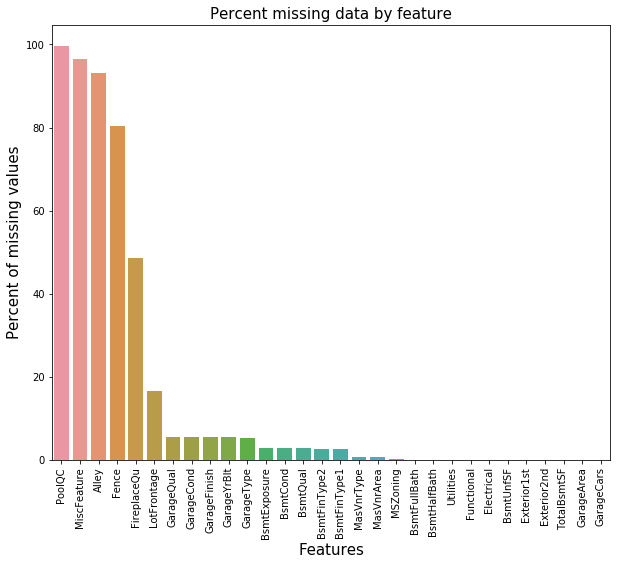

In [7]:
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [19]:
%%capture
'''
version 1: handle missing data

#missing data 
total = df_data_train.isnull().sum().sort_values(ascending=False)
percent = (df_data_train.isnull().sum()/df_data_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#missing_data.head(20)

test_total = df_data_test.isnull().sum().sort_values(ascending=False)
test_percent = (df_data_test.isnull().sum()/df_data_test.isnull().count()).sort_values(ascending=False)
test_missing_data = pd.concat([test_total, test_percent], axis=1, keys=['Total', 'Percent'])
#test_missing_data.head(20)

df_data_train = df_data_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_data_train = df_data_train.drop(df_data_train.loc[df_data_train['Electrical'].isnull()].index)
df_data_train.isnull().sum().max()

df_data_test = df_data_test.drop((missing_data[missing_data['Total'] > 1]).index,1)

null_columns=df_data_test.columns[df_data_test.isnull().any()]
#print(df_data_test[df_data_test.isnull().any(axis=1)][null_columns].head())

#test data 處理missing value numerical
numeric_features = df_data_test.select_dtypes(include=[np.number])
numeric_features.columns
for col in (['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
             'GarageCars','GarageArea']):
    df_data_test[col]=df_data_test[col].fillna(0)
    
#test data 處理missing value categorical
for col in  ('Exterior1st','Exterior2nd','KitchenQual','SaleType'):
    df_data_test[col]=df_data_test[col].fillna(df_data_train[col].mode()[0])

'''


In [8]:
# data description says NA means "no object"
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [9]:
'''
LotFrontage :Group by neighborhood and fill in missing 
value by the median LotFrontage of all the neighborhood
'''

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [10]:
#GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [11]:
'''
GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 
(Since No garage = no cars in such garage.
'''

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [12]:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath :
#missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 
#For all these categorical basement-related features, NaN means that there is no basement.    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [13]:
#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses.
#We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

#MSZoning (The general zoning classification) : 'RL' is by far the most common value. 
#So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [14]:
'''
Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
Since the house with 'NoSewa' is in the training set, this feature won't help in 
predictive modelling. We can then safely remove it.
'''
all_data = all_data.drop(['Utilities'], axis=1)

'''
Functional : data description says NA means typical
'''

all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [15]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [16]:
#MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [17]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


#### Transforming some numerical variables that are really categorical

In [18]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### Adding one more important feature

In [19]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### Skewed features

In [20]:
'''
version1 : deal with skewness
numerics=df_data_train.dtypes[df_data_train.dtypes !='object'].index
skewed= df_data_train[numerics].skew()
skewed= skewed[skewed>0.75]
skewed= skewed.index
df_data_train[skewed]=np.log1p(df_data_train[skewed])

df_data_test[skewed]=np.log1p(df_data_test[skewed])

df_data_train['GrLivArea'] = np.log(df_data_train['GrLivArea'])

df_data_test['GrLivArea'] = np.log(df_data_test['GrLivArea'])
'''
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
#skewness.head(10)

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])


Skew in numerical features: 



#### get dummy

In [21]:
'''
version 1
%%capture
houses=pd.concat([df_data_train,df_data_test], sort=False)
houses=pd.get_dummies(houses)
'''

all_data = pd.get_dummies(all_data)

train = all_data[:ntrain]
test = all_data[ntrain:]
x=train
y=df_data_train['SalePrice'] 

In [24]:
y.count()

1458

In [27]:
#df_data_test.describe()

### Model(XGBOOST)
https://segmentfault.com/a/1190000014040317 <br/>
https://www.kaggle.com/goldens/regression-xgboost <br/>
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [203]:
'''
version 1

train=houses[:len(df_data_train)]
test=houses[len(df_data_train):]
train.drop('Id', axis=1, inplace=True)
x=train.drop('SalePrice', axis=1) 
y=train['SalePrice'] 

test.drop('Id', axis=1, inplace=True)
test=test.drop('SalePrice', axis=1)
test.head()
'''

In [22]:
housematrix=xgb.DMatrix(data=x, label=y)

In [23]:
xgb_param_grid = {'colsample_bytree':[0.05,0.07, 0.1 ,0.12, 0.15 , 0.2, 0.25, 0.3],'n_estimators':[300,400,500,600,700,800,900,1000],'max_depth':[2,3,4]}

In [24]:
xgb_inst= xgb.XGBRegressor(learning_rate=0.05)

In [25]:
xgb_grid = GridSearchCV(estimator= xgb_inst, param_grid = xgb_param_grid,scoring='neg_mean_squared_error', cv=5, verbose=1)

#scores_xgb=cross_val_score(xgb_grid,x,y,scoring='neg_mean_squared_error',cv=2)

In [26]:
start_time = time.time()

xgb_grid.fit(x,y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 12.6min finished


--- 756.8397550582886 seconds ---


In [16]:
scores_xgb=cross_val_score(xgb_grid,x,y,scoring='neg_mean_squared_error',cv=2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.0min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.0min finished


In [33]:
scores_xgb

array([-0.01735577, -0.01495307])

In [29]:
#%%capture
xgb_grid.best_estimator_
xgb_results = xgb_grid.cv_results_
#xgb_results

In [30]:
xgb_results = xgb_grid.cv_results_
max(xgb_results["mean_test_score"])

-0.013128905722708745

In [261]:
scores  = xgb_results['mean_test_score'].reshape(len(xgb_param_grid["colsample_bytree"]),
                                       len(xgb_param_grid["n_estimators"])*len(xgb_param_grid["max_depth"])) 

In [263]:
len(scores)

7

ValueError: num must be 1 <= num <= 4, not 5

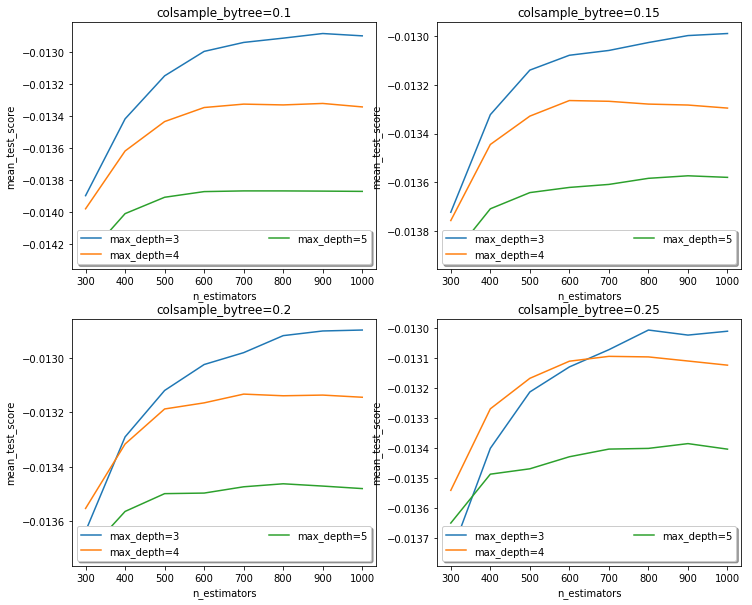

In [262]:
plt.figure(figsize=(12, 10))
rowcount=len(xgb_param_grid["n_estimators"]) #3
colcount=len(xgb_param_grid["max_depth"]) #4

for item in range(len(scores)):
    temp_item = scores[item].reshape(colcount, rowcount)
    plt.subplot(2,2,item+1)
    plt.title("colsample_bytree="+str(xgb_param_grid["colsample_bytree"][item]))
    plt.xlabel('n_estimators')
    plt.ylabel('mean_test_score')
    for i in range(len(temp_item)):
        plt.plot(xgb_param_grid["n_estimators"] , temp_item[i],label="max_depth="+str(xgb_param_grid["max_depth"][i]))
        leg =plt.legend(loc='lower center', ncol=2, mode="expand", shadow=True, fancybox=True)

plt.show()

In [31]:
import pickle

#保存Model
with open('xgb_grid_v2.pickle', 'wb') as f:
    pickle.dump(xgb_grid, f)
   

'''
#读取Model
with open('xgb_grid.pickle', 'rb') as f:
    xgb_grid = pickle.load(f)
    #测试读取后的Model
    #print(xgb_grid.predict(X[0:1]))

'''

"\n#读取Model\nwith open('xgb_grid.pickle', 'rb') as f:\n    xgb_grid = pickle.load(f)\n    #测试读取后的Model\n    #print(xgb_grid.predict(X[0:1]))\n\n"

In [32]:
#df_data_test.head()
pred=xgb_grid.predict(test)
preds=np.exp(pred)

output = pd.DataFrame({'Id': testID,'SalePrice': preds})

In [33]:
output.to_csv('submission.csv', index=False) 

## 小結
2019/2/13 (1):
1. train data缺失值處理 : 大部分直接刪除
2. test data缺失值處理 : 使用mode 及補0
3. model : xgboost及 grid search <br/>
ps: pd.get_dummies() 需先將train data及test data concate
4. 正確率 0.1313 (1709/4072)

2019/2/13 (2):
1. 調整xgboost參數colsample_bytree=0.2, n_estimators=500, max_depth=3
2. mean_test_score = -0.0133
3. 正確率 0.12463 (1306/4072)

2019/2/13 (3):
1. 調整xgboost參數colsample_bytree=0.1, n_estimators=900, max_depth=3
2. mean_test_score = -0.01288
3. 正確率 0.12437 (1280/4072)

2019/2/15 (1):
1. 做feature engineering
2. mean_test_score = -0.01313
3. 正確率 0.12841 (1297/4072)

## MODEL LightGBM

In [37]:
import lightgbm as lgb
lgb_param_grid = {'n_estimators':[500,600,700,800,900,1000],'num_leaves':[4,5,6]}

In [38]:
lgb_inst = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [39]:
lgb_grid = GridSearchCV(estimator= lgb_inst, param_grid = lgb_param_grid,scoring='neg_mean_squared_error', cv=5, verbose=1)

In [40]:
start_time = time.time()

lgb_grid.fit(x,y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   34.8s finished


--- 35.06625270843506 seconds ---


In [ ]:
lgb_results = lgb_grid.cv_results_
max(xgb_results["mean_test_score"])